**Step 1: Importing the Dataset**

The following code cells will import necessary libraries and import the dataset from the repository as a Pandas DataFrame

In [2]:
#import sys
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
import tensorflow as tf

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

2022-12-14 22:06:38.154003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import pandas as pd
import numpy as np
import os

import joblib

from keras import utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional, Attention
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras

**Step 2: Preprocessing the Dataset**

The data is not in a usable form; as a result, we will need to process it before using it to train our algorithms.

In [5]:
df = pd.read_csv('../model_input/NonPromoterSequence.txt', sep = '>', )
df.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df.reset_index(inplace = True)
df.drop(['EP 1 (+) mt:CoI_1; range -400 to -100.', 'index'], axis = 1, inplace=True) #data cleaning after error found
df.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df['label'] = 0

df2 = pd.read_csv('../model_input/PromoterSequence.txt', sep = '>', )
df2.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
df2.reset_index(inplace = True)
df2.drop(['EP 1 (+) mt:CoI_1; range -100 to 200.', 'index'], axis = 1, inplace=True)
df2.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
df2['label'] = 1

df = pd.concat([df, df2], axis = 0 )
df.shape

(22600, 2)

In [6]:
df.drop([1822], inplace = True)

for seq in df['sequence']:
    if 'N' in seq:
        display(df.loc[df['sequence'] == seq])

sequence = list(df.loc[:, 'sequence'])
encoded_list = []

In [8]:
def encode_seq(s):
    Encode = {'A':[1,0,0,0],'T':[0,1,0,0],'C':[0,0,1,0],'G':[0,0,0,1]}
    return [Encode[x] for x in s]

for i in sequence:
    x = encode_seq(i)
    encoded_list.append(x)

X = np.array(encoded_list)
X.shape

(22598, 301, 4)

In [9]:
y = df['label']
y.shape
X.shape

(22598, 301, 4)

**Step 3: Training and Testing Neural Networks**

Now that we have preprocessed the data and built our training and testing datasets, we can start to deploy different convultional neural network architectures. It's relatively easy to test multiple models using gridsearch; as a result, we will compare and contrast the perforance using GridSearchCV over many values.

In [10]:
X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, test_size = 0.1, random_state = 42, stratify = y)
y_train = utils.to_categorical(y_train)

X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, random_state = 42, stratify = y_not_train, test_size=0.5)

y_val = utils.to_categorical(y_val)
y_test = utils.to_categorical(y_test)

X_train = tf.cast(X_train, dtype='float32')
X_val = tf.cast(X_val, dtype='float32')
X_test = tf.cast(X_test, dtype='float32')

2022-12-14 22:06:52.927838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 22:06:52.929983: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [11]:
params = {
    'first_node': [128, 64],
    'second_node': [32, 64],
    'alpha': [0.001, 0.01],
    'first_filter': [9, 16, 32], 
    'dropout': [0.1, 0.2, 0.5]
}
#used for GridSearchCV

In [13]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters = 60, kernel_size = (4), activation = 'relu', input_shape = (301, 4))) # 298 * 60
cnn_model.add(MaxPooling1D(pool_size = (3))) # 99 * 60
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(filters = 60, kernel_size = (2), activation = 'relu', padding = 'same')) # 99 * 30
cnn_model.add(MaxPooling1D(pool_size = (3))) # 33 * 15
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(filters = 30, kernel_size = (2), activation = 'relu', padding = 'same')) # 33 * 30
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(64, activation = 'relu'))
cnn_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
cnn_model.add(Dense(2, activation = 'sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0003, patience=8, 
                                           restore_best_weights=True )
history = cnn_model.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=20)

Epoch 1/20
159/159 [==============================] - 14s 86ms/step - loss: 0.6766 - accuracy: 0.7164 - val_loss: 0.5630 - val_accuracy: 0.7531
Epoch 2/20
159/159 [==============================] - 13s 84ms/step - loss: 0.4847 - accuracy: 0.7897 - val_loss: 0.4606 - val_accuracy: 0.8044
Epoch 3/20
159/159 [==============================] - 12s 73ms/step - loss: 0.4197 - accuracy: 0.8150 - val_loss: 0.3951 - val_accuracy: 0.8363
Epoch 4/20
159/159 [==============================] - 10s 66ms/step - loss: 0.3706 - accuracy: 0.8397 - val_loss: 0.3437 - val_accuracy: 0.8478
Epoch 5/20
159/159 [==============================] - 14s 91ms/step - loss: 0.3402 - accuracy: 0.8539 - val_loss: 0.3238 - val_accuracy: 0.8549
Epoch 6/20
159/159 [==============================] - 14s 90ms/step - loss: 0.3238 - accuracy: 0.8631 - val_loss: 0.3140 - val_accuracy: 0.8584
Epoch 7/20
159/159 [==============================] - 13s 84ms/step - loss: 0.3054 - accuracy: 0.8736 - val_loss: 0.3068 - val_accuracy:

In [14]:
# save model
cnn_model.save('CNN_model')

INFO:tensorflow:Assets written to: CNN_model/assets


INFO:tensorflow:Assets written to: CNN_model/assets


In [15]:
# load model
cnn_model = keras.models.load_model('CNN_model')

In [17]:
pred = cnn_model.predict

In [18]:
preds = cnn_model.predict(X_test)

36/36 [==============================] - 1s 18ms/step


In [19]:
preds
len(preds)

1130

In [20]:
np.savetxt("test_predictions.txt", preds, delimiter=",")

In [21]:
# get accuracy
# positive: is promoter
tn = 0
fn = 0
fp = 0
tp = 0

for i in range(len(preds)):
  if preds[i][0] >= preds[i][1]: # non-promoter
    preds[i][0] = 1
    preds[i][1] = 0
  else:                          # promoter
    preds[i][0] = 0
    preds[i][1] = 1

for i in range(len(preds)):
  if(preds[i][0] > preds[i][1]): # non-promoter
    if y_test[i][0] == 1:
      tn += 1
    else:
      fn += 1
  else:                          # promoter
    if y_test[i][1] == 1:
      tp += 1
    else:
      fp += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fn + fp + tn)
print(precision, recall, accuracy)
print(tp, fn, fp, tn)

0.8960302457466919 0.8389380530973451 0.8707964601769912
474 91 55 510


In [22]:
print(cnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 298, 60)           1020      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 99, 60)           0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 99, 60)            0         
                                                                 
 conv1d_7 (Conv1D)           (None, 99, 60)            7260      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 33, 60)           0         
 1D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 33, 60)           

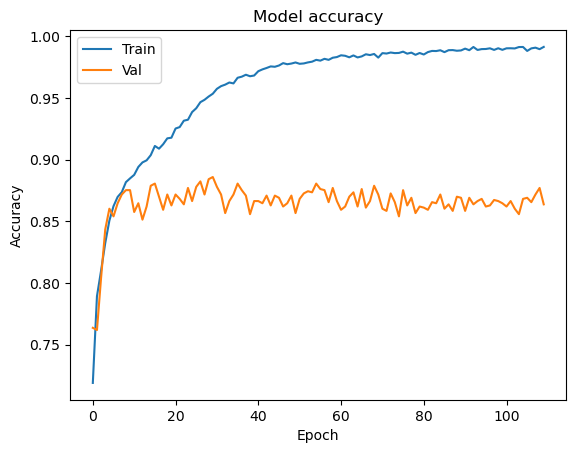

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('only CNN accuracy')

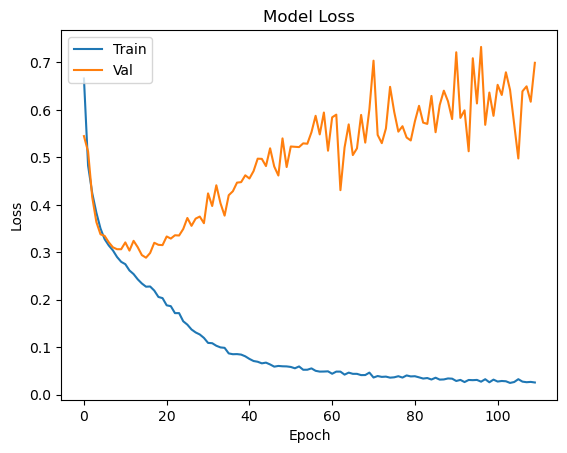

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig('only CNN loss')